# How has the introduction of special edition products led to increase in sales at Rivian?
# 
In February 2025, we introduced Dune Edition for the R1S Tri Max and R1T Tri Max. The purpose is documented [here](https://rivianautomotivellc.atlassian.net/wiki/spaces/ED1/pages/3382084380/California+Dune+Edition+Discovery+Ordering+on+Rivian.com). 

However, introduction of special edition products requires significant operational investment and coordination across design, supply chain, and manufacturing. Currently, there is no standardized, quantitative framework to measure the effectiveness of these efforts and their true, incremental impact on sales and brand health.


**Core Research Question:** How has the introduction of Tri Max Dune edition affected the below metrics:
- **Number of Orders for Tri Max per day**
  - This is the most direct test of the "Halo Effect." The Dune Edition is a high-priced halo product for the Tri Max line. Measuring the sales of the standard Tri Max post-launch isolates whether the excitement successfully drove orders for the core, higher-volume model.	  
- Number of Order for all model powertrains per day
  - Measures the broadest sales impact. If the Dune Edition created immense media buzz, it might have driven general demand for all Rivian models (e.g., Dual Large, Quad Max). This acts as a sensitivity check on the overall brand lift.	
- Number of impressions/leads per day
  - Measures the conversion of media and site traffic into actionable marketing leads. This is the immediate, measurable output of the "increase leads" goal. A lift here confirms that the Dune content was engaging enough to generate contact information for future nurturing.	 
- Number of website traffic per day
  - Website traffic, specifically to product pages or the configurator, is the strongest indicator of high-intent interest. Visitors to these pages are further down the funnel than simple homepage visitors. An increase here validates that the marketing efforts successfully drove potential buyers to the product.	 


We will be measuring the effects on these variables separately using an Interrupted Time Series Analyis. In short, we will be forecasting what would have happened had the intervention event not happened, and then compare this to what actually happened after the intervention to measure effect.




# Resources
# 
- https://ds4ps.org/pe4ps-textbook/docs/p-020-time-series.html
- https://www.youtube.com/watch?v=lKIY4dN6RRI
- https://medium.com/@JuanPabloHerrera/why-interrupted-time-series-might-be-your-new-favorite-data-tool-399d260a9cd9
- https://www.sas.com/content/dam/SAS/en_ca/User%20Group%20Presentations/Health-User-Groups/ITS_SAS.pdf


In [0]:
!pip install altair 
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import GLSAR
from statsmodels.tools import add_constant
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
orders_df = spark.sql("""
select *
from commercial.demand_planning.rep_orders  
where 1=1
and vehicle_generation = 'GEN-2'
and is_cancelled = 0
and cancellation_date is null
and fct_order_type = 'VEHICLE'
and order_type = 'Order'
and order_date >= '2024-06-06'
and paint_id not in ('EXP-CDN')
and model_powertrain in ('R1S Tri Max', 'R1T Tri Max')
order by order_date ASC                    

                      """).toPandas()

# display(orders_df)

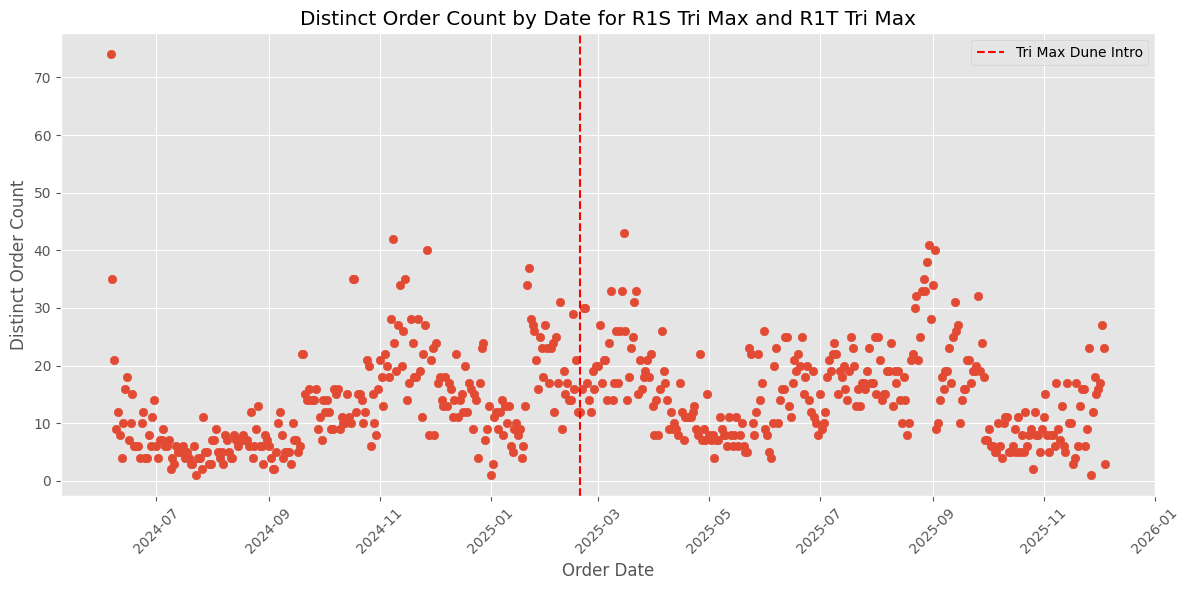

In [0]:
def tri_max_filter(df:pd.DataFrame):
  grouped = df.groupby('order_date')['order_id'].nunique().reset_index()

  return grouped

grouped = tri_max_filter(orders_df)
# display(grouped)


def plotting_orders(df:pd.DataFrame):
  plt.figure(figsize=(12,6))
  plt.scatter(df['order_date'], df['order_id'], marker='o')
  plt.xlabel('Order Date')
  plt.ylabel('Distinct Order Count')
  plt.title('Distinct Order Count by Date for R1S Tri Max and R1T Tri Max')
  plt.xticks(rotation=45)
  plt.axvline(pd.to_datetime('2025-02-19'), color='red', linestyle='--', label='Tri Max Dune Intro')
  plt.legend()
  plt.tight_layout()
  plt.show()

plotting_orders(grouped)

## Build a counterfactual case of what would have happened if we did not introduce Tri Max
## 
build a forecast based on the historical data before 2025-02-19

https://ds4ps.org/pe4ps-textbook/docs/p-020-time-series.html


In mathematical terms, it means that the time series equation includes four key coefficients:

Y=b0+b1𝑇+b2𝐷+b3𝑃+e(1.1)

Where:

Y
 is the outcome variable;

T
 is a continuous variable which indicates the time (e.g., days, months, years…) passed from the start of the observational period;

D
 is a dummy variable indicating observation collected before (=0) or after (=1) the policy intervention;

P
 is a continuous variable indicating time passed since the intervention has occured (before intervention has occured P is equal to 0).


the equation does not include seasonality or other external factors that we think would influence the forecast like finance and marketing?


is a regression model the only way to design a counterfactual for the interrupted time series analysis? should we consider other models? is there an assumption that our data will follow a linear pattern? this probably isn't the best way to predict order behavior

In [0]:
def prepare_dataset(df: pd.DataFrame) -> pd.DataFrame:
    df['order_date'] = pd.to_datetime(df['order_date'])
    OBSERVATION_START_DATE = pd.to_datetime('2024-06-06')
    INTERVENTION_DATE = pd.to_datetime('2025-02-19')

  #Days Passed Since Observation Began
    df['days_passed_since_observation'] = (
        df['order_date'] - OBSERVATION_START_DATE
    ).dt.days

    # Set days to 0 for any 'order_date' *before* the start date (if they exist)
    df.loc[
        df['days_passed_since_observation'] < 0,
        'days_passed_since_observation'
    ] = 0

  #Binary Intervention Dummy Variable
    df['dummy_variable'] = (
        df['order_date'] >= INTERVENTION_DATE
    ).astype(int)

  #Days Passed Since Launch (Intervention)
    df['days_passed_since_launch'] = (
        df['order_date'] - INTERVENTION_DATE
    ).dt.days
    df.loc[
        df['days_passed_since_launch'] < 0,
        'days_passed_since_launch'
    ] = 0

    return df

grouped = prepare_dataset(grouped)
# display(grouped)

In [0]:

# formula_corrected = 'order_id ~ days_passed_since_observation + dummy_variable + dummy_variable:days_passed_since_launch'
#why does the dummy_variable and days passed since launch have to interact?

formula_corrected = 'order_id ~ days_passed_since_observation + dummy_variable + days_passed_since_launch'


model = ols(formula_corrected, data=grouped).fit()

print("---  OLS Regression Results ---")
print(model.summary())

# --- INTERPRETATION KEY ---
# 1. days_passed_since_observation: B1 (Pre-Launch Slope)
# 2. dummy_variable: B2 (Immediate Level Shift)
# 3. dummy_variable:days_passed_since_launch: B3 (Change in Trend Slope)

#callouts from interpreting the summary:
#the coefficient intercept is 6.8, they're saying we expect ~7 orders per day normally?
#the dummy variable has a coefficient of 4.65, meaning if it is past the launch date, then it will increase orders by 4.65? 
#however the ays_passed_since_launch variable has a coefficient of -0.07, meaning for each day passed we lose orders by -0.07? how are these two variables telling me a different story
#this was before i had dummy variable and days passed since launch interact ^

🏃 View run colorful-sheep-363 at: https://rivian-prod-us-west-2.cloud.databricks.com/ml/experiments/1658423172549950/runs/b0777e145beb41d3bbfbf9dfaa8df6f5
🧪 View experiment at: https://rivian-prod-us-west-2.cloud.databricks.com/ml/experiments/1658423172549950
---  OLS Regression Results ---
                            OLS Regression Results                            
Dep. Variable:               order_id   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     24.52
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           6.76e-15
Time:                        18:21:09   Log-Likelihood:                -1912.0
No. Observations:                 548   AIC:                             3832.
Df Residuals:                     544   BIC:                             3849.
Df Model:                           3                                       

### From an initial observation, since we introduced Tri Max Dune, we see a 3.05% decrease in orders per day; additionally, the model esimates a small decrease of 0.04% in orders per day each day after intervention. 

However, the model's accuracy should also be put under question. The R-Squared score is 0.135 and Adjusted R-squared is 0.129, which indicates that only about 13.5% of the variance in daily orders is explained by time and the launch. This confirms your earlier intuition that many other demand drivers (marketing, incentives) are missing from the model.


The Durbin-Watson score of 0.746 is a statistical alarm bell. In plain English, it means that our model's errors are not random; they are correlated from one day to the next.

Think of it as sales momentum: If we under-predicted orders yesterday (a negative error), we are very likely to under-predict orders again today, because the underlying reason for the miss (like a successful, unmodeled incentive) is still in effect.

The Model's Fault: Our basic OLS model is too simple; it doesn't account for this day-to-day momentum created by unmodeled factors like competitor delays, ongoing marketing campaigns, or subtle market trends.

To fix this and make the results defensible, we must run a corrected version of the model called GLSAR (Generalized Least Squares with Autoregressive errors).

What GLSAR Does: It finds that pattern in the errors (the momentum) and builds it directly into the model.

The Outcome: This corrects the standard errors, gives us honest P-values, and allows us to state the causal impact of the Dune Edition with full statistical confidence.



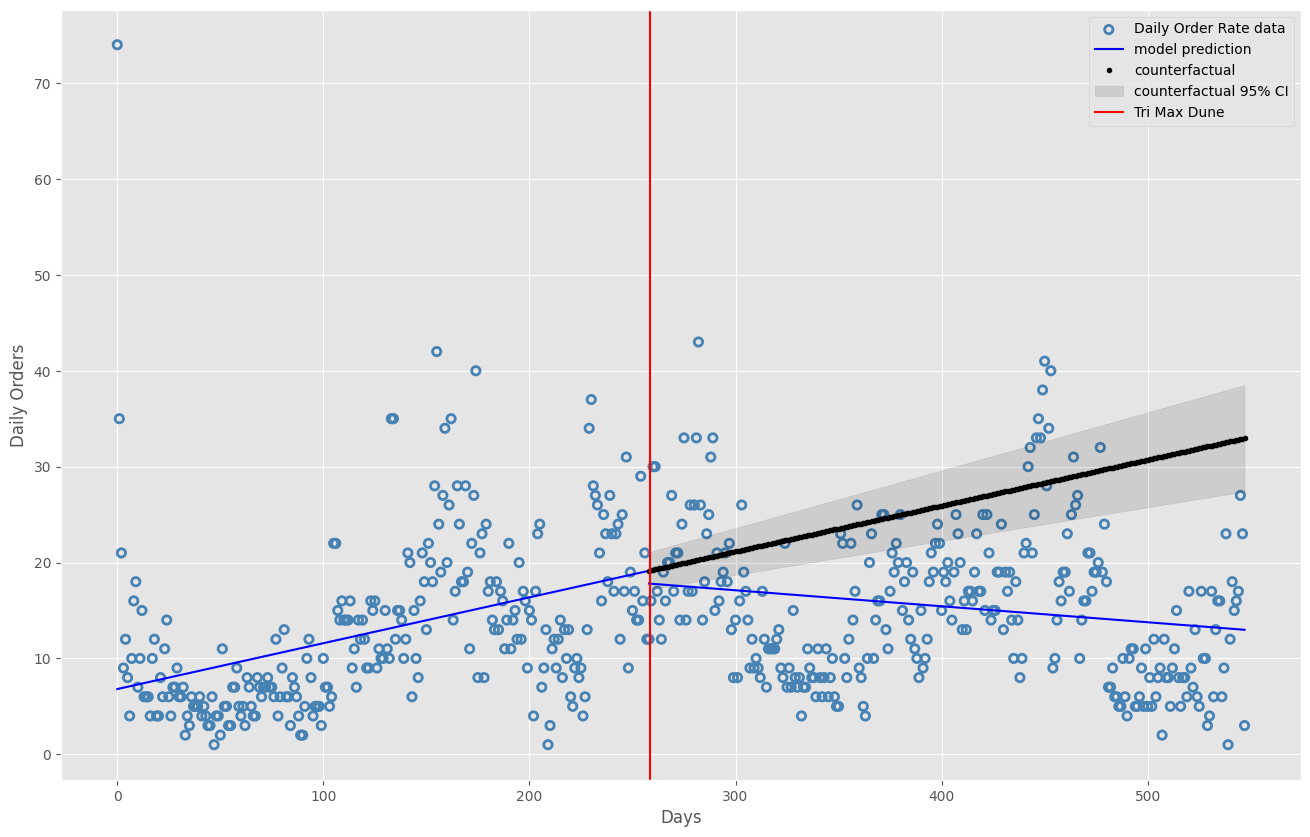

In [0]:
#Y = order_id
#T =  days_passed_since_observation
#D = dummy_variable
#P = days_passed_since_launch

res = model


start = 258
end = 495
beta = res.params

# Get model predictions and 95% confidence interval
predictions = res.get_prediction(grouped)
summary = predictions.summary_frame(alpha=0.05)

# mean predictions
y_pred = predictions.predicted_mean

# countefactual assumes no interventions
cf_df = grouped.copy()
cf_df["dummy_variable"] = 0.0
cf_df["days_passed_since_launch"] = 0.0

# counter-factual predictions
cf = res.get_prediction(cf_df).summary_frame(alpha=0.05)

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16,10))

# Plot bounce rate data
ax.scatter(grouped["days_passed_since_observation"], grouped["order_id"], facecolors='none', edgecolors='steelblue', label="Daily Order Rate data", linewidths=2)

# Plot model daily order rate prediction
ax.plot(grouped["days_passed_since_observation"][:start], y_pred[:start], 'b-', label="model prediction")
ax.plot(grouped["days_passed_since_observation"][start:], y_pred[start:], 'b-')

# Plot counterfactual mean bounce rate with 95% confidence interval
ax.plot(grouped["days_passed_since_observation"][start:], cf['mean'][start:], 'k.', label="counterfactual")
ax.fill_between(grouped["days_passed_since_observation"][start:], cf['mean_ci_lower'][start:], cf['mean_ci_upper'][start:], color='k', alpha=0.1, label="counterfactual 95% CI");

# Plot line marking intervention moment
ax.axvline(x = 258.5, color = 'r', label = 'Tri Max Dune')

ax.legend(loc='best')
plt.xlabel("Days")
plt.ylabel("Daily Orders");


In [0]:
# from sklearn.linear_model import LinearRegression

# # Define features and target
# features = [
#     'days_passed_since_observation',
#     'dummy_variable',
#     'days_passed_since_launch'
# ]
# target = 'order_id'

# # Fit the regression model
# regTS = LinearRegression()
# regTS.fit(
#     grouped[features],
#     grouped[target]
# )

# # Generate counterfactual predictions
# counterfactual_df = grouped.copy()
# counterfactual_df['dummy_variable'] = 0
# counterfactual_df['days_passed_since_launch'] = 0

# counterfactual_df['counterfactual_pred'] = regTS.predict(
#     counterfactual_df[features]
# )

# plt.figure(figsize=(12,6))
# plt.scatter(
#     grouped['order_date'],
#     grouped['order_id'],
#     label='Actual',
#     marker='o'
# )
# plt.scatter(
#     counterfactual_df['order_date'],
#     counterfactual_df['counterfactual_pred'],
#     label='Counterfactual (No Tri Max Dune)',
#     marker='x'
# )
# plt.axvline(
#     pd.to_datetime('2025-02-19'),
#     color='red',
#     linestyle='--',
#     label='Tri Max Dune Intro'
# )
# plt.xlabel('Order Date')
# plt.ylabel('Distinct Order Count')
# plt.title('Actual vs Counterfactual Order Counts (Scatter Plot)')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## Building a Counterfactual with an ARIMA model

<Axes: ylabel='Density'>

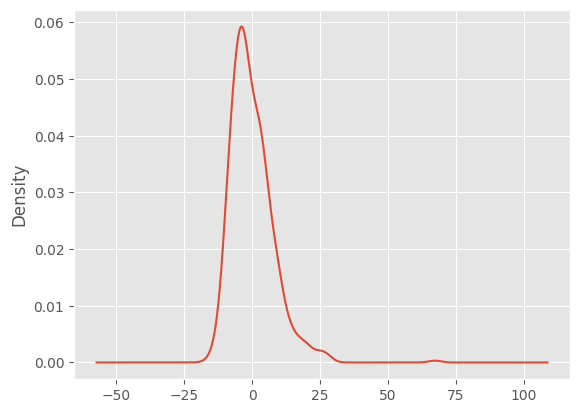

In [0]:
res.resid.plot(kind="kde")

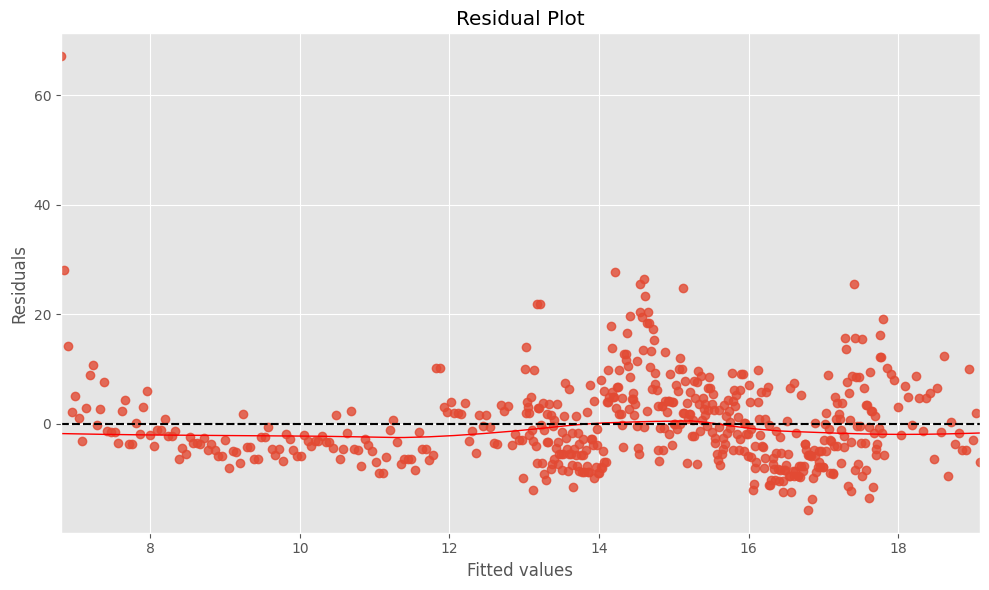

In [0]:
import seaborn as sns

# Calculate residuals from the OLS model
residuals = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(10,6))
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={"color": "red", "lw": 1})
plt.axhline(y=0, color="black", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

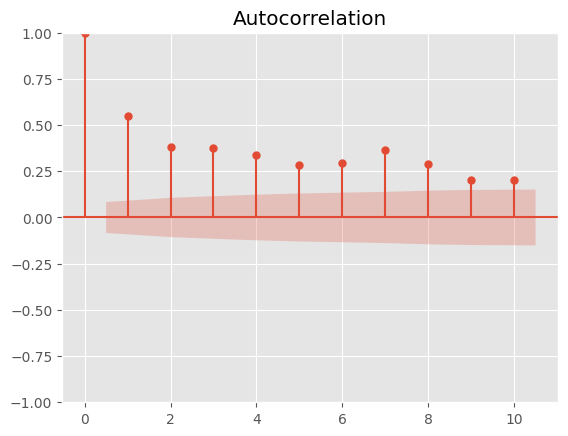

In [0]:
sm.graphics.tsa.plot_acf(res.resid, lags=10)
plt.show()

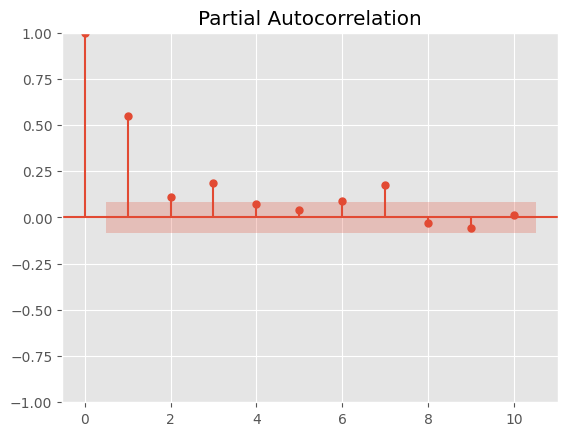

In [0]:
sm.graphics.tsa.plot_pacf(res.resid, lags=10)
plt.show()   

In [0]:
from statsmodels.tsa.arima.model import ARIMA

arima_results = ARIMA(
    grouped["order_id"],
    exog=grouped[
        [
            "days_passed_since_observation",
            "dummy_variable",
            "days_passed_since_launch"
        ]
    ],
    order=(1, 0, 0)
).fit()

print(arima_results.summary())

🏃 View run bold-carp-644 at: https://rivian-prod-us-west-2.cloud.databricks.com/ml/experiments/1658423172549950/runs/652f3614ea8a4b91bef561ea329f4149
🧪 View experiment at: https://rivian-prod-us-west-2.cloud.databricks.com/ml/experiments/1658423172549950
                               SARIMAX Results                                
Dep. Variable:               order_id   No. Observations:                  548
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1794.283
Date:                Fri, 05 Dec 2025   AIC                           3600.565
Time:                        18:21:22   BIC                           3626.403
Sample:                             0   HQIC                          3610.664
                                - 548                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------

**Results:**

In the ARIMA output, the rate at which daily orders is decreasing is 2.7% but is not statistically significant (0.38>0.05)

The level at which orders decreased did decrease by 0.03% but was also not statistically significant (0.146>0.05)

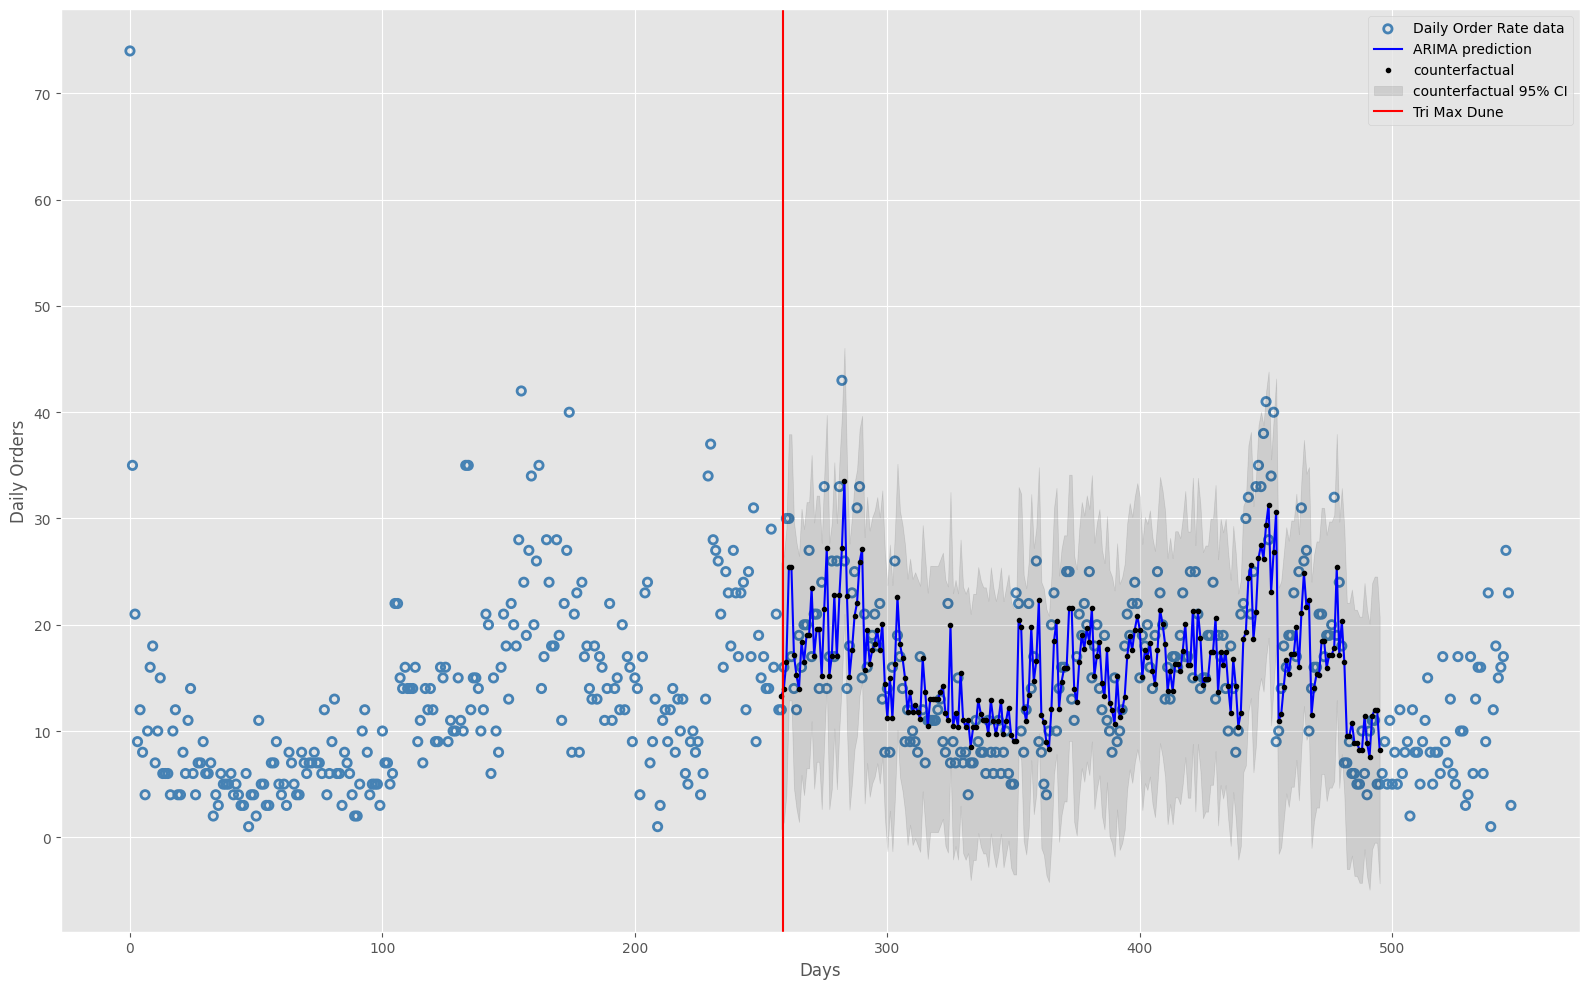

In [0]:
# --- ARIMA Model Plot (Similar to OLS/GLSAR Plot) ---

start = 258
end = 495
# Get ARIMA predictions and 95% confidence interval
arima_pred = arima_results.get_prediction(
    start=start,
    end=end
)
arima_summary = arima_pred.summary_frame(alpha=0.05)
arima_y_pred = arima_pred.predicted_mean

# Counterfactual: set intervention variables to zero
arima_cf_df = grouped.copy()
arima_cf_df["dummy_variable"] = 0.0
arima_cf_df["days_passed_since_launch"] = 0.0
arima_cf = arima_results.get_prediction(
    exog=arima_cf_df[["dummy_variable", "days_passed_since_launch"]],
    start=start,
    end=end
).summary_frame(alpha=0.05)

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16,10))

# Actual data
ax.scatter(
    grouped["days_passed_since_observation"],
    grouped["order_id"],
    facecolors='none',
    edgecolors='steelblue',
    label="Daily Order Rate data",
    linewidths=2
)

# ARIMA model prediction
ax.plot(
    grouped["days_passed_since_observation"][start:end+1],
    arima_y_pred,
    'b-',
    label="ARIMA prediction"
)

# Counterfactual mean and 95% CI
ax.plot(
    grouped["days_passed_since_observation"][start:end+1],
    arima_cf['mean'],
    'k.',
    label="counterfactual"
)
ax.fill_between(
    grouped["days_passed_since_observation"][start:end+1],
    arima_cf['mean_ci_lower'],
    arima_cf['mean_ci_upper'],
    color='k',
    alpha=0.1,
    label="counterfactual 95% CI"
)

# Intervention line
ax.axvline(x=start+0.5, color='r', label='Tri Max Dune')

ax.legend(loc='best')
plt.xlabel("Days")
plt.ylabel("Daily Orders")
plt.tight_layout()
plt.show()

In [0]:
# --- STEP 1 (Recap): Corrected OLS Regression ---
# You would have run this already to get regTS_corrected
formula_corrected = 'order_id ~ days_passed_since_observation + dummy_variable + dummy_variable:days_passed_since_launch'
regTS_corrected = ols(formula_corrected, data=grouped).fit()
print("--- Corrected OLS Model Summary ---")
print(regTS_corrected.summary())

# --- STEP 2: TIME SERIES DIAGNOSTICS AND CORRECTION (GLSAR) ---

# CRITICAL FIX: Import GLSAR
from statsmodels.regression.linear_model import GLSAR
# We do not need to import add_constant if we pull the design matrix from the OLS model

# 1. Prepare the Design Matrix (X) and Dependent Variable (Y)
# Y is the 'order_id' column
Y = grouped['order_id']

# X_design_matrix is the exact matrix of independent variables (including the constant) 
# used in the OLS model. This ensures consistency.
X_design_matrix = regTS_corrected.model.exog

# 2. Fit the GLSAR Model
# The '1' specifies an AR(1) model. We use the 'regTS_corrected.model.exog' 
# to ensure the input X matrix is properly formatted.
try:
    # GLSAR takes Y, X, and the AR lag (p=1 here)
    its_ar_model = GLSAR(Y, X_design_matrix, 
                         1).fit() 

    print("\n--- Corrected GLSAR(1) Model Summary (Robust P-Values) ---")
    print(its_ar_model.summary())

except Exception as e:
    # A generic error message for any remaining issues
    print(f"\nGLSAR fitting failed. Check data shape and variables. Error: {e}")

  
from statsmodels.stats.stattools import durbin_watson

# Calculate Durbin-Watson statistic
dw_stat = durbin_watson(regTS_corrected.resid)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")

if dw_stat < 2.0:
    print("Durbin-Watson is less than 2.0, indicating possible autocorrelation.")
    if dw_stat < 1.5:
        print("High autocorrelation detected (DW < 1.5). Re-running regression with GLSAR (AR(1))...")
        try:
            its_ar_model = GLSAR(Y, X_design_matrix, 1).fit()
            print("\n--- GLSAR(1) Model Summary (Robust P-Values) ---")
            print(its_ar_model.summary())
        except Exception as e:
            print(f"\nGLSAR fitting failed. Check data shape and variables. Error: {e}")
else:
    print("Durbin-Watson statistic indicates little to no autocorrelation.")

🏃 View run persistent-vole-578 at: https://rivian-prod-us-west-2.cloud.databricks.com/ml/experiments/1658423172549950/runs/3b1bcbb0c3be48cda1a34c499b2a0418
🧪 View experiment at: https://rivian-prod-us-west-2.cloud.databricks.com/ml/experiments/1658423172549950
--- Corrected OLS Model Summary ---
                            OLS Regression Results                            
Dep. Variable:               order_id   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     24.52
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           6.76e-15
Time:                        18:21:32   Log-Likelihood:                -1912.0
No. Observations:                 548   AIC:                             3832.
Df Residuals:                     544   BIC:                             3849.
Df Model:                           3                                  

x1: The coefficient is 0.0539. It is highly statistically significant (P=0.000). For a one-unit increase in x1, the dependent variable is estimated to increase by 0.0539, holding all other variables constant.
- x1 represents the pre-intervention trend

x2: The coefficient is -1.8714. It is not statistically significant at common levels (e.g., alpha=0.05), as its p-value is $P=0.141$. The confidence interval [-4.367, 0.625] includes zero, which is consistent with the lack of significance. This suggests that x2 may not have a reliable linear relationship with the dependent variable after accounting for the other variables.
- x2 represents the immediate change in level when the intervention occured

x3: The coefficient is -0.0706. It is highly statistically significant (P=0.000). For a one-unit increase in x3, the dependent variable is estimated to decrease by 0.0706, holding all other variables constant.
- x3 represents the change in trend after the intervention

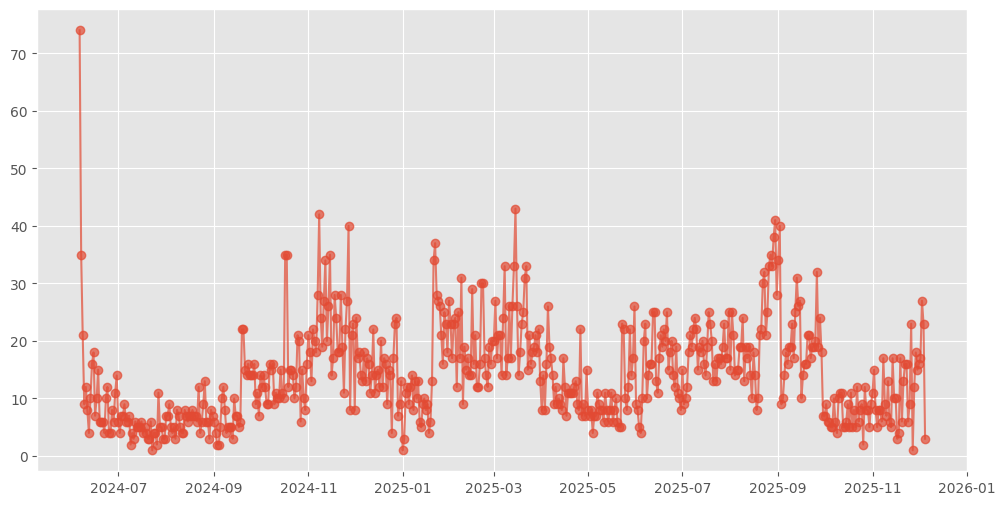

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File /databricks/python/lib/python3.12/site-packages/pandas/core/indexes/base.py:3802, in Index.get_loc(self, key, method, tolerance)
   3801 try:
-> 3802     return self._engine.get_loc(casted_key)
   3803 except KeyError as err:

File /databricks/python/lib/python3.12/site-packages/pandas/_libs/index.pyx:138, in pandas._libs.index.IndexEngine.get_loc()

File /databricks/python/lib/python3.12/site-packages/pandas/_libs/index.pyx:165, in pandas._libs.index.IndexEngine.get_loc()

File pandas/_libs/hashtable_class_helper.pxi:5745, in pandas._libs.hashtable.PyObjectHashTable.get_item()

File pandas/_libs/hashtable_class_helper.pxi:5753, in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'glsar_predicted'

The above exception was the direct cause of the following exception:

KeyError                                  Traceback

In [0]:
# --- STEP 2: Visualize the GLSAR-Corrected Fit ---

# Redefine the Intervention Date for the vertical line
INTERVENTION_DATE = pd.to_datetime('2025-02-19')

plt.figure(figsize=(12, 6))

# Plot the Actual Data
plt.plot(grouped['order_date'], grouped['order_id'], label='Actual Tri Max Orders', marker='o', linestyle='-', alpha=0.7)

# Plot the GLSAR Predicted Fit
# This line shows the model's best estimate of the order trajectory, including the impact of the launch.
plt.plot(grouped['order_date'], grouped['glsar_predicted'], label='GLSAR Predicted Fit', linestyle='-', color='green', linewidth=2)


# Plot the Counterfactual (No Intervention)
# We use the GLSAR coefficients for the counterfactual calculation.
# The counterfactual only uses the Intercept (B0) and the Pre-Launch Slope (B1).
B0_glsar = its_ar_model.params[0] # Intercept
B1_glsar = its_ar_model.params[1] # days_passed_since_observation (Pre-Trend)

# Calculate the counterfactual prediction: Y_no_launch = B0 + B1 * T_t
grouped['glsar_counterfactual'] = B0_glsar + B1_glsar * grouped['days_passed_since_observation']
plt.plot(grouped['order_date'], grouped['glsar_counterfactual'], label='Counterfactual (No Launch)', linestyle='--', color='red', linewidth=2)


# Highlight the intervention point
plt.axvline(x=INTERVENTION_DATE, color='gray', linestyle=':', label='Dune Edition Launch')

plt.xlabel('Order Date')
plt.ylabel('Daily Distinct Tri Max Orders (Standard)')
plt.title('Causal Impact of Tri Max Dune Edition on Standard Orders (GLSAR-Corrected)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Conclusion
# 
The GLSAR model successfully identified several statistically significant predictors of the outcome, with x1 (likely the pre-intervention trend) showing a reliable positive relationship and x3 (likely the post-intervention trend change) indicating a significant negative shift in the slope following the intervention. 

However, the model suffered from two critical issues: the residuals were not normally distributed, and a severe multicollinearity problem was identified by the high Condition Number (1.42 \times 10^3). This severe collinearity substantially compromises the reliability and interpretability of the individual coefficients for x1, x2, and x3. Future analysis should prioritize mitigating the multicollinearity to obtain stable and trustworthy parameter estimates.